<a href="https://colab.research.google.com/github/youngnamh/PyTorch/blob/main/titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting Imports

In [191]:
from google.colab import drive

drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Data

In [192]:
training_data = pd.read_csv('/content/drive/My Drive/titanic/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/titanic/test.csv')


#Starting Data


In [193]:
training_data[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [194]:
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#Correlation Map

<ipython-input-195-f1c513e8c49f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(training_data.corr(), cmap="YlGnBu")


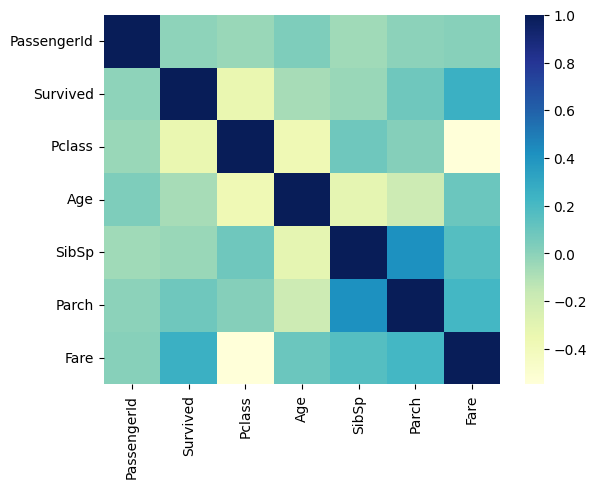

In [195]:
import seaborn as sns

sns.heatmap(training_data.corr(), cmap="YlGnBu")
plt.show()

Heat map shows which values are either strongly correlated or negatively corelated with survived. There are certain values that do not show up since they are not numeric, for example: Sex. We will have to change those values to numbers since they will be strongly correlated.

#Split Data
We want to split the training data once again in order to train and test using exclusively the training data. Generally you do not want to look at the real testing data beforehand. Thus we will create new test data and training data from our training data.

Even if training data and test data is split randomly, by chance the training data can be not reflective of the testing data and vica versa. Thus we split the data based on certain key values (ex: survived, sex, Pclass) so that there should be fairly equal proportions of those values in the training data and test data

In [196]:
from tables.tests.test_suite import test
from sklearn.model_selection import StratifiedShuffleSplit

#use SSSplit to divide in two, 0.2 for a 80% 20% distribution of training vs test data
split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

#Make sure data is split to have equal proportions of Survived, Sex, and Pclass
for train_indices, test_indices in split_data.split(training_data, training_data[["Survived", "Pclass", "Sex"]]):
  strat_train_set = training_data.loc[train_indices]
  strat_test_set = training_data.loc[test_indices]

 #for now, just changings it temporarily ***
  strat_train_set_container = strat_train_set
  strat_train_set = training_data

#Evenly split data

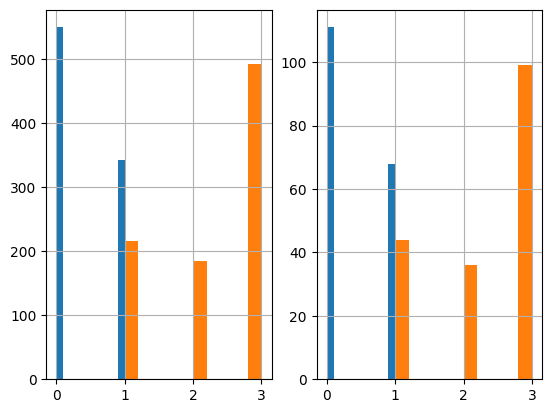

In [197]:
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()

Blue represents survival (0 - did not survive, 1 -did survive)

Orange represents Pclass (there are 3 different levels of passenger class)

As you can see there is an equal proportion of these factors in each data set

#Missing data?

In [198]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- over 100 missing ages
- Mostly missing cabin numbers (will most likely drop)

#Estimate and fill missing data

give passengers with missing age the mean age


In [199]:
#BaseEstimator used to define an estimator
#Transformermixin lets us use fit and transform together without defining them explicitely
#SimpleImputer lets us fill missing data with some strategy ex:mean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer (BaseEstimator,TransformerMixin) :

  def fit(self,X,y=None):
    return self

  def transform(self, X):
    imputer = SimpleImputer(strategy="mean")
    X['Age'] = imputer.fit_transform(X[['Age']])
    return X

# One hot encoding

transforming values that are not numeric into binary columns (ex: The column Sex with possible values "male" and "female" will now be 2 seperate rows with values 0 or 1 )

In [200]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEncoder (BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    encoder = OneHotEncoder()

    matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
    column_names = ["C","S","Q","N"]

    for i in range(len(matrix.T)): # .T because we transpose the matrix to flip from column to row
      X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[["Sex"]]).toarray()
    column_names = ["Female", "Male"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    return X


#Drop unneeded data

In [201]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper (BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"], axis=1, errors="ignore")

#Pipeline

The Lists of steps that the data goes through to clean it and get it in a good state to train the model. Basically adding all the tools we just created together.

In [202]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [203]:
#apply the pipeline, we should now have no missing data

strat_test_cleaned = pipeline.fit_transform(strat_test_set)
strat_train_cleaned = pipeline.fit_transform(strat_train_set)

strat_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   C            891 non-null    float64
 8   S            891 non-null    float64
 9   Q            891 non-null    float64
 10  Female       891 non-null    float64
 11  Male         891 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 83.7 KB


#Scale Data

In [204]:
#scale everything an give numpy arrays

from sklearn.preprocessing import StandardScaler

#training data
X_train = strat_train_cleaned.drop(['Survived'], axis=1)
y_train = strat_train_cleaned['Survived']

#testing data
X_val = strat_test_cleaned.drop(['Survived'], axis=1)
y_val = strat_test_cleaned['Survived']

#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = y_train.to_numpy()

X_val = scaler.fit_transform(X_val)
y_val = y_val.to_numpy()

X_train.shape, X_val.shape,y_train.shape, y_val.shape

((891, 11), (179, 11), (891,), (179,))

#Build Model

In [205]:
import torch
import torch.nn as nn
import torch.nn.functional as func

class TitanicModel(nn.Module):
  def __init__(self):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(11, 165)
        self.fc2 = nn.Linear(165, 2)

  def forward(self, x):
      x = self.fc1(x)
      x = func.dropout(x, p=0.1)
      x = func.relu(x) #for non-linearity
      x = self.fc2(x)
      x = func.sigmoid(x) #for binary solutions

      return x

model = TitanicModel()


In [206]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.2812,  0.2399,  0.2168,  ...,  0.2237, -0.2792,  0.0186],
                      [ 0.0265,  0.0027, -0.1839,  ...,  0.1949, -0.0495, -0.1230],
                      [ 0.1565, -0.2562, -0.1099,  ..., -0.0474,  0.0434, -0.2245],
                      ...,
                      [ 0.1848, -0.0276,  0.1865,  ..., -0.0584, -0.0947, -0.2842],
                      [-0.1592, -0.0356, -0.0523,  ...,  0.1546, -0.1983, -0.0662],
                      [-0.0497, -0.2247, -0.2122,  ..., -0.0683,  0.0236, -0.1669]])),
             ('fc1.bias',
              tensor([ 0.1381, -0.1296,  0.2373, -0.1087,  0.1993,  0.2909, -0.1821,  0.2573,
                      -0.1778, -0.0866, -0.2409,  0.0476,  0.1182,  0.2713,  0.0520, -0.0745,
                       0.1117,  0.1504,  0.0347, -0.0809,  0.1630,  0.2549, -0.1251,  0.0630,
                      -0.1329, -0.1042,  0.1846,  0.2454, -0.0618, -0.1078, -0.1739, -0.2303,
                       0.2083, -0.15

#Choosing optimizer and loss functions

In [207]:
batch_size = 50
num_epochs = 200
learning_rate = 0.01
batch_no = len(X_train) // batch_size

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

#Training the Model

In [208]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    X_train, y_train = shuffle(X_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = model(x_var)
        loss = criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()

Epoch 1
Epoch 6
Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46
Epoch 51
Epoch 56
Epoch 61
Epoch 66
Epoch 71
Epoch 76
Epoch 81
Epoch 86
Epoch 91
Epoch 96
Epoch 101
Epoch 106
Epoch 111
Epoch 116
Epoch 121
Epoch 126
Epoch 131
Epoch 136
Epoch 141
Epoch 146
Epoch 151
Epoch 156
Epoch 161
Epoch 166
Epoch 171
Epoch 176
Epoch 181
Epoch 186
Epoch 191
Epoch 196


# Evaluate the model

In [209]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(X_val), requires_grad=True)
with torch.no_grad():
    result = model(test_var)
values, labels = torch.max(result, 1)
num_right = np.sum(labels.data.numpy() == y_val)
print('Accuracy {:.2f}'.format(num_right / len(y_val)))

Accuracy 0.88


#Final Test


In [210]:
from sklearn.preprocessing import StandardScaler

# the final test data in csv
test = pd.read_csv('/content/drive/My Drive/titanic/test.csv')
test_data_cleaned = pipeline.fit_transform(test)
test_data_cleaned = test_data_cleaned.fillna(method="ffill") ## fills any missing data. In this case fare number

scaler = StandardScaler()
test_data_final = scaler.fit_transform(test_data_cleaned)

#test_data_cleaned.info()
#test_data_final
test_data_final.shape

(418, 11)

#Predictions

In [211]:
X_test_var = Variable(torch.FloatTensor(test_data_final), requires_grad=True)
with torch.no_grad():
    test_result = model(X_test_var)
values, labels = torch.max(test_result, 1)
predictions = labels.data.numpy()
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

#Save Results as CSV



In [213]:
test = pd.read_csv('/content/drive/My Drive/titanic/test.csv')

final_result = pd.DataFrame(test['PassengerId'])
final_result['Survived'] = predictions
final_result.to_csv('/content/drive/My Drive/titanic/predictions.csv', index=False)


#FINISHED!!!!